### 2D advection Level Set Method on cartesian mesh

In [1]:
using Plots
using LinearAlgebra

In [2]:
pyplot()

Plots.PyPlotBackend()

##### Functions

In [156]:
# Homogeneous 2D neumann boundary conditions (to be used)
function neumann_top(phi,N)
    phi[2,2:N+1]
end
function neumann_bottom(phi,N)
    phi[end-1,2:N+1]
end
function neumann_left(phi,N)
    phi[2:N+1,2]
end
function neumann_right(phi,N)
    phi[2:N+1,end-1]
end

# Cartesian grid initialisation 
function grid(L0,h,N)
    [ -L0 + 2*h*(i-1) for i=1:N+1, j = 1:N+1]
end

# Cell centers for VOF formulation
function cell_center(X,N)
    0.5(X[1:N,1:N]+X[2:N+1,2:N+1])
end

# Initialisation of level set function phi 
function init_circle(X,Y,radius,N)
    R = radius*[1 for i = 1:N, j = 1:N];
    sqrt.(X.^2 + Y.^2) - R
end

# On a 3x3 stencil, if the integrated flux from adjacent to central cell
# is negative, mark them and use them. (Mikula, 2007)
function find_inflow(phibc,n,i,j,h,c)
        stencil = Array{CartesianIndex{3},1}(undef, 0); # Coordinates of cells of interest
        for k = i-1:2:i+1 # the 2 adjacent cells in the x direction
            # Computation of integrated flux
            a = h*(-c)*((phibc[n,k,j]-phibc[n,i,j])/sqrt(((phibc[n,k,j]-phibc[n,i,j])^2))) 
            if a < 0.
                # add the cell coordinates to the array
                push!(stencil,CartesianIndex(n, k, j))
            end
        end
        for k = j-1:2:j+1 # the 2 adjacent cells in the y direction
            a = h*(-c)*((phibc[n,i,k]-phibc[n,i,j])/sqrt(((phibc[n,i,k]-phibc[n,i,j])^2)))
            if a < 0.
                push!(stencil,CartesianIndex(n, i, k))
            end
        end
        stencil
end

find_inflow (generic function with 2 methods)

##### Parameters

In [186]:
N = 250 # number of grid points
L0 = 1.25 # domain size
h = L0/N # grid spacing

radius = 1. # initial radius of the circle
c = 1. # constant driving force

eps = h^2
CFL = 1
Tmax = 0.1
tau = 0.005 # time step (respects CFL condition)
#tau = CFL*h # time step (respects CFL condition)
#nt = trunc(Int, Tmax/tau);
nt = 160;
nt*tau

0.8

##### Initialisation

In [187]:
# Mesh initalisation
#X = cell_center(transpose(grid(L0,h,N)),N);
#Y = cell_center(grid(L0,h,N),N);

X = cell_center(transpose(grid(L0,h,N)),N);
Y = cell_center(grid(L0,h,N),N);

In [188]:
# Level set function initialisation
phibc = zeros(nt+1,N+2,N+2)
#phibc[2:N+2,2:N+2] = X
phibc[1,2:N+1,2:N+1] = init_circle(X,Y,radius,N);
#phibc

In [189]:
#phibc = phibc/findmax(phibc)[1]
# Neumann BC with one ghost layer
phibc[1,1,2:N+1] = phibc[1,2,2:N+1];

phibc[1,end,2:N+1] = phibc[1,end-1,2:N+1]
phibc[1,2:N+1,1] = phibc[1,2:N+1,2]
phibc[1,2:N+1,end] = phibc[1,2:N+1,end-1]

phi0 = phibc[1,2:N+1,2:N+1];
#phibc 

##### Main loop

In [190]:
for n = 1:nt # Time loop
    for i = 2:N+1 # x loop
        for j = 2:N+1 # y loop
            lv = 0. # initialisation of rhs
            cm = 0.
            stc = find_inflow(phibc,n,i,j,h,c) # find the cells of interest
            
            if length(stc) > 0 # if no cell is found then phi(n+1) = phi(n)
                for k = 1:length(stc)
                    # for each cell of interest compute
                    # the "leaving" and "coming" terms
                    lv += (-1.) *(-c)*(phibc[stc[k]]-phibc[n,i,j])/sqrt((phibc[stc[k]]-phibc[n,i,j])^2)
                    cm += (-1.) *(-c)*phibc[stc[k]]*(phibc[stc[k]]-phibc[n,i,j])/sqrt((phibc[stc[k]]-phibc[n,i,j])^2)
                    # modify here the flux calculation for the MOC
                end     
            end
            
            # update the level set function
            phibc[n+1,i,j] = phibc[n,i,j]*(1. - (tau/h^2)*lv) + (tau/h^2)*cm
            
            
        end
    end
#contour(X,Y,[phibc[n,2:N+1,2:N+1],phi0,phi_a],nlevels=1,clims=(0,2))    
# Neumann BC applied at each time step    
phibc[n+1,1,2:N+1] = phibc[n,2,2:N+1];
phibc[n+1,end,2:N+1] = phibc[n,end-1,2:N+1]
phibc[n+1,2:N+1,1] = phibc[n,2:N+1,2]
phibc[n+1,2:N+1,end] = phibc[n,2:N+1,end-1]
end    

##### Post-processing

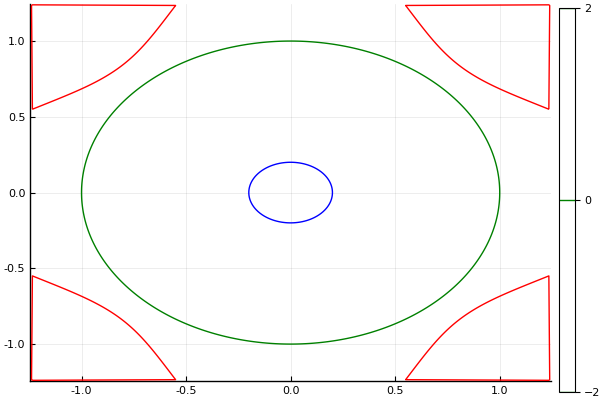

In [195]:
rad_a = radius - nt*tau;
phi_a = init_circle(X,Y,rad_a,N)
contour(X,Y,[phi0],levels=0,label=["Analytical" "Numerical" ],linecolor = ["green"])
contour!(X,Y,[phi_a],levels=0,label=["Analytical" "Numerical" ],linecolor = ["blue"])
contour!(X,Y,[phibc[2,2:N+1,2:N+1]],levels=0,label=["Analytical" "Numerical" ],linecolor = ["red"])
#contour(X,Y,[phi0],levels=0) 

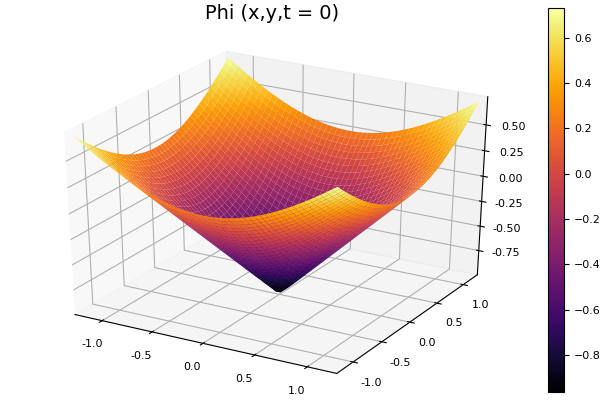

In [115]:
plot(X,Y,phi0 ,st=:surface,camera=(30,30),title = "Phi (x,y,t = 0)")
#savefig("/Users/tomas/PhD/2019-2020/julia/JuLSM/Phi_t0.png")

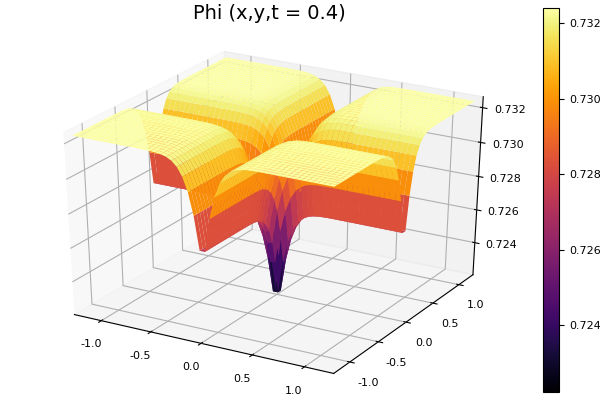

In [164]:
plot(X,Y,phibc[end,2:N+1,2:N+1],st=:surface,camera=(30,30),title = "Phi (x,y,t = 0.4)")
#savefig("/Users/tomas/PhD/2019-2020/julia/JuLSM/Phi_t0_4.png")